In [261]:
import os
import warnings
import random

import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader, Subset
import torch.nn.functional as F

from tqdm import tqdm
from PIL import Image
from PIL import ImageEnhance
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from sklearn.model_selection import train_test_split, KFold
from sklearn.preprocessing import LabelEncoder

In [154]:
warnings.filterwarnings("ignore", category=FutureWarning)

In [156]:
path = "C:/Users/timof/Desktop/HumanMood/EmotionsDataset/data" 

In [263]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

## Introduction

Распознавание эмоций человека при помощи различных CNN моделей (LeNet5 и AlexNet), используя библиотеку PyTorch и вспомогательные: NumPy, Matplotlib, pandas, PIL, sklearn. <p> 

Датасет: https://www.kaggle.com/datasets/muhammadhananasghar/human-emotions-datasethes/data

## Augementation

Расширение датасета путём изменения яркости, контраста и отражения изображения по горизонтали

В репозитории приложена директория с уже расширенным датасетом

In [160]:
def augementation(input_directory, output_directory):

    os.makedirs(output_directory, exist_ok=True)

    for filename in os.listdir(input_directory):
        if filename.lower().endswith('.jpg'):

            img_path = os.path.join(input_directory, filename)
            image = Image.open(img_path)

            flipped_image = image.transpose(Image.FLIP_LEFT_RIGHT)

            enhancer_brightness_09 = ImageEnhance.Brightness(image)
            bright_image_09 = enhancer_brightness_09.enhance(0.9)

            enhancer_brightness_09 = ImageEnhance.Brightness(flipped_image)
            bright_flipped_image_09 = enhancer_brightness_09.enhance(0.9)

            enhancer_contrast_09 = ImageEnhance.Contrast(image)
            contrast_image_09 = enhancer_contrast_09.enhance(0.9)

            enhancer_contrast_09 = ImageEnhance.Contrast(flipped_image)
            flipped_contrast_image_09 = enhancer_contrast_09.enhance(0.9)
    
            bright_image_09.save(os.path.join(output_directory, f'brightness_0.9_{filename}'))
            bright_flipped_image_09.save(os.path.join(output_directory, f'flipped_brightness_0.9_{filename}'))
            contrast_image_09.save(os.path.join(output_directory, f'contrast_0.9_{filename}'))
            flipped_contrast_image_09.save(os.path.join(output_directory, f'flipped_contrast_0.9_{filename}'))
            flipped_image.save(os.path.join(output_directory, f'flipped_image_{filename}'))


In [161]:
# augementation("C:/Users/timof/Desktop/HumanMood/EmotionsDataset/data/angry", "C:/Users/timof/Desktop/HumanMood/angry")
# augementation("C:/Users/timof/Desktop/HumanMood/EmotionsDataset/data/sad", "C:/Users/timof/Desktop/HumanMood/sad")
# augementation("C:/Users/timof/Desktop/HumanMood/EmotionsDataset/data/happy", "C:/Users/timof/Desktop/HumanMood/happy")

### READING FILES

In [166]:
def read_data_from_dir(path) -> dict:
    data_dict = {"image":[],
             "mood":[]}
    for i in os.walk(path):
        if i[2] != []:
            label = i[0].split('\\')[-1]
            for name in i[2]:
                img = np.array(Image.open(f"{i[0]}/{name}").convert("L"))
                
                data_dict["image"].append(img)
                data_dict["mood"].append(label)
    return data_dict

In [168]:
data_dict = read_data_from_dir(path)
data = pd.DataFrame(data=data_dict)
data_shuffle = data.sample(frac=1, random_state=42).reset_index(drop=True)

In [169]:
label_encoder = LabelEncoder()
data_shuffle['mood'] = label_encoder.fit_transform(data_shuffle['mood'])

In [249]:
classes = label_encoder.classes_
print("Соответствие классов и их индексов:")
for i, class_name in enumerate(classes):
    print(f"{class_name}: {i}")

Соответствие классов и их индексов:
angry: 0
happy: 1
sad: 2


## VIEWING DATA

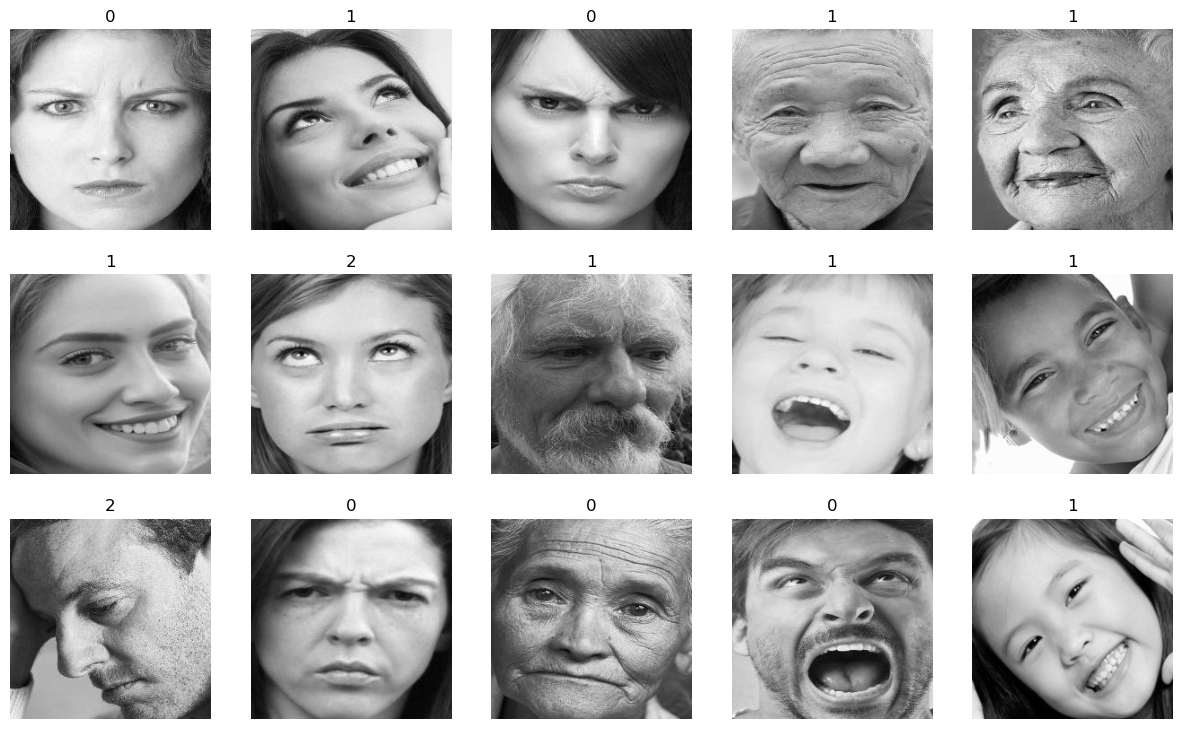

In [171]:
fig, axs = plt.subplots(3, 5, figsize=(15, 9))

for i in range(15):
    
    num_row = i // 5
    num_col = i % 5
    
    row = data_shuffle.iloc[i]
    axs[num_row, num_col].imshow(row[0], cmap="gray")
    axs[num_row, num_col].axis('off')
    axs[num_row, num_col].set_title(f'{row[1]}')

## Models

In [173]:
class LeNet5(nn.Module):
    def __init__(self, num_classes):
        super(LeNet5, self).__init__()

        self.conv1 = nn.Conv2d(in_channels=1, out_channels=6, kernel_size=5)
        self.pool1 = nn.AvgPool2d(kernel_size=2, stride=2)
        self.conv2 = nn.Conv2d(in_channels=6, out_channels=16, kernel_size=5)
        self.pool2 = nn.AvgPool2d(kernel_size=2, stride=2)
        self.conv3 = nn.Conv2d(in_channels=16, out_channels=120, kernel_size=5)

        self.fc1 = nn.Linear(120 * 57 * 57, 84)  
        self.fc2 = nn.Linear(84, num_classes) 

    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(x)
        x = self.pool1(x)

        x = self.conv2(x)
        x = F.relu(x)
        x = self.pool2(x)
        
        x = self.conv3(x)
        x = F.relu(x)

        x = x.view(-1, 120 * 57 * 57) 

        x = F.relu(self.fc1(x))                 
        x = self.fc2(x)                         
        
        return x 

In [240]:
class AlexNet(nn.Module):
    def __init__(self, num_classes=3):
        super(AlexNet, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=64, kernel_size=11, stride=4, padding=2) 
        self.conv2 = nn.Conv2d(in_channels=64, out_channels=192, kernel_size=5, padding=2)
        self.conv3 = nn.Conv2d(in_channels=192, out_channels=384, kernel_size=3, padding=1)
        self.conv4 = nn.Conv2d(in_channels=384, out_channels=256, kernel_size=3, padding=1)
        self.conv5 = nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, padding=1)

        self.fc1 = nn.Linear(256 * 1 * 1, 4096) 
        self.fc2 = nn.Linear(4096, 4096)
        self.fc3 = nn.Linear(4096, num_classes)

        self.pool = nn.MaxPool2d(kernel_size=3, stride=2)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        x = self.pool(F.relu(self.conv4(x)))
        x = self.pool(F.relu(self.conv5(x)))

        x = x.view(x.size(0), -1)
   
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        x = F.relu(self.fc2(x))
        x = F.dropout(x, training=self.training)
        x = self.fc3(x)

        return x

## PREPROCESSING

In [243]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[1], std=[1]),
    transforms.Resize((256, 256))
])

In [245]:
class CustomImageDataset(Dataset):
    def __init__(self, dataframe, transform=None):
        self.dataframe = dataframe
        self.transform = transform

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        img_array = self.dataframe.iloc[idx, 0] 
        label = self.dataframe.iloc[idx, 1]  
        
        if self.transform:
            image = transform(img_array)

        if image.ndimension() == 2:  
            image = image.unsqueeze(0) 

        return image, label.astype("int64")

## TRAINING

Обучение проходит с кросс-валидацией (KFold) с последующим сохранением модели, которая показала наилучший accuracy на валидационной части

In [296]:
def train(train_model, num_epochs, n_splits, trainset, batch_size, path_best_model, num_classes, learning_rate):
    
    kfold = KFold(n_splits=n_splits, shuffle=True)
    indices = list(range(len(trainset)))
    best_accuracy = 0
    
    for fold, (train_idx, val_idx) in enumerate(kfold.split(indices)):
        print(f'Fold {fold + 1}')

        model = LeNet5(num_classes=num_classes).to(device)
        criterion = nn.CrossEntropyLoss()
        optimizer = optim.Adam(model.parameters(), lr=learning_rate)


        train_subset = Subset(trainset, train_idx)
        val_subset = Subset(trainset, val_idx)
    
        trainloader = DataLoader(train_subset, batch_size=batch_size, shuffle=True, num_workers=0)
        valloader = DataLoader(val_subset, batch_size=batch_size, shuffle=False, num_workers=0)
    
        for epoch in range(num_epochs):
            model.train()
            for inputs, labels in trainloader:
    
                inputs, labels = inputs.to(device), labels.to(device)
                optimizer.zero_grad()
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                loss.backward()
                optimizer.step()
     
            model.eval()
            correct = 0
            total = 0
            with torch.no_grad():
                for inputs, labels in valloader:
                    inputs, labels = inputs.to(device), labels.to(device)
                    outputs = model(inputs)
                    _, predicted = torch.max(outputs.data, 1)
                    total += labels.size(0)
                    correct += (predicted == labels).sum().item()
            print(f'Accuracy for fold {fold + 1}/epoch {epoch+1}: {100 * correct / total:.2f}%\n')
            
            accuracy = 100 * correct / total
            if accuracy > best_accuracy:
                best_accuracy = accuracy
                best_model_weights = model.state_dict() 
    
    if best_model_weights is not None:
        torch.save(best_model_weights, path_best_model)
        print(f'Best model weights saved with accuracy: {best_accuracy:.2f}%')


In [298]:
trainset = CustomImageDataset(dataframe=data_shuffle, transform=transform)
learning_rate = 0.001
num_classes = 3
train_model = LeNet5(num_classes=num_classes).to(device)
num_epochs = 25
n_splits = 10
batch_size = 64
path_best_model = "best_model_weights_LeNet5.pth"

In [304]:
train(train_model, num_epochs, n_splits, trainset, batch_size, path_best_model, num_classes, learning_rate)

Fold 1
Accuracy for fold 1/epoch 1: 56.20%

Accuracy for fold 1/epoch 2: 68.65%

Accuracy for fold 1/epoch 3: 72.22%

Accuracy for fold 1/epoch 4: 81.29%

Accuracy for fold 1/epoch 5: 82.75%

Accuracy for fold 1/epoch 6: 83.80%

Accuracy for fold 1/epoch 7: 83.45%

Accuracy for fold 1/epoch 8: 83.51%

Accuracy for fold 1/epoch 9: 84.04%

Accuracy for fold 1/epoch 10: 83.63%

Accuracy for fold 1/epoch 11: 83.51%

Accuracy for fold 1/epoch 12: 83.68%

Accuracy for fold 1/epoch 13: 82.87%

Accuracy for fold 1/epoch 14: 82.87%

Accuracy for fold 1/epoch 15: 83.57%

Accuracy for fold 1/epoch 16: 82.81%

Accuracy for fold 1/epoch 17: 83.16%

Accuracy for fold 1/epoch 18: 82.69%

Accuracy for fold 1/epoch 19: 83.22%

Accuracy for fold 1/epoch 20: 83.22%

Accuracy for fold 1/epoch 21: 83.33%

Accuracy for fold 1/epoch 22: 82.92%

Accuracy for fold 1/epoch 23: 82.69%

Accuracy for fold 1/epoch 24: 83.27%

Accuracy for fold 1/epoch 25: 82.46%

Fold 2
Accuracy for fold 2/epoch 1: 63.57%

Accuracy